In [340]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cluster import KMeans



## 1. Data Loading and Cleaning

Loading the employee dataset, which contains historical attrition records to forms the basis for predicting which employees are likely to accept a severance package (RCC).

To ensure clean inputs for modeling, we:
- Drop constant or ID-like columns (`EmployeeCount`, `StandardHours`, `EmployeeNumber`, `Over18`)
- Fill missing numeric values with column means
- Encode categorical variables using `LabelEncoder`


Missing Data Handling: Instead of removing employees with missing values, we impute using column averages. This ensures we retain all records for RCC probability prediction without biasing the model.

In [341]:
#  Load the dataset
df = pd.read_csv("employee_attrition_previous_closure.csv")

# Quick preview of the data
display(df.head())

# Summary statistics for numerical variables
print("Summary Statistics:")
display(df.describe())

# Check for missing values
print("\nMissing Values:")
display(df.isnull().sum())

# Replace missing numeric values with column means
df_cleaned = df.copy()
for col in df_cleaned.select_dtypes(include=[np.number]).columns:
    df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mean())

# Drop constant or irrelevant columns
columns_to_remove = ['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18', 'MaritalStatus', 'Education', 'EducationField']
df_cleaned.drop(columns=columns_to_remove, inplace=True, errors='ignore')

# Encode categorical variables using LabelEncoder
df_encoded = df_cleaned.copy()
label_encoders = {}
for col in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le



,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,No,50.0,Travel_Rarely,1126.0,Research & Development,1.0,2,Medical,1,997,...,3,80,1,32,1,2,5,4,1,3
1,No,36.0,Travel_Rarely,216.0,Research & Development,6.0,2,Medical,1,178,...,4,80,2,7,0,3,3,2,0,1
2,Yes,21.0,Travel_Rarely,337.0,Sales,7.0,1,Marketing,1,1780,...,2,80,0,1,3,3,1,0,1,0
3,No,50.0,Travel_Frequently,1246.0,Human Resources,NaN,3,Medical,1,644,...,3,80,1,32,2,3,32,5,10,7
4,No,52.0,Travel_Rarely,994.0,Research & Development,7.0,4,Life Sciences,1,1118,...,4,80,0,18,4,3,8,6,4,0


Summary Statistics:


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,893.000000,1002.000000,934.000000,1029.000000,1029.0,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,...,1029.000000,1029.0,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000,1029.000000
mean,37.930571,800.528942,9.930407,2.892128,1.0,1024.367347,2.683188,66.680272,2.713314,2.043732,...,2.689990,80.0,0.822157,11.196307,2.782313,2.748299,6.942663,4.215743,2.119534,4.005831
std,9.395978,408.109828,8.421791,1.053541,0.0,606.301635,1.096829,20.474094,0.710146,1.118918,...,1.077767,0.0,0.874662,7.857581,1.283401,0.697278,6.068322,3.658595,3.108651,3.522574
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,458.250000,2.000000,2.000000,1.0,496.000000,2.000000,48.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,37.000000,801.500000,8.000000,3.000000,1.0,1019.000000,3.000000,67.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,44.000000,1162.000000,16.000000,4.000000,1.0,1553.000000,4.000000,84.000000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,10.000000,7.000000,2.000000,7.000000
max,60.000000,1496.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,37.000000,18.000000,15.000000,17.000000



Missing Values:


Attrition                     0
Age                         136
BusinessTravel                5
DailyRate                    27
Department                    0
DistanceFromHome             95
Education                     0
EducationField                0
EmployeeCount                 0
EmployeeNumber                0
EnvironmentSatisfaction       0
Gender                        0
HourlyRate                    0
JobInvolvement                0
JobLevel                      0
JobRole                       0
JobSatisfaction               0
MaritalStatus                 5
MonthlyIncome                 0
MonthlyRate                   0
NumCompaniesWorked            0
Over18                        0
OverTime                      0
PercentSalaryHike             0
PerformanceRating             0
RelationshipSatisfaction      0
StandardHours                 0
StockOptionLevel              0
TotalWorkingYears             0
TrainingTimesLastYear         0
WorkLifeBalance               0
YearsAtC

In [342]:
print(df_encoded.head())

   Attrition   Age  BusinessTravel  DailyRate  Department  DistanceFromHome  \
0          0  50.0               2     1126.0           1          1.000000   
1          0  36.0               2      216.0           1          6.000000   
2          1  21.0               2      337.0           2          7.000000   
3          0  50.0               1     1246.0           0          9.930407   
4          0  52.0               2      994.0           1          7.000000   

   EnvironmentSatisfaction  Gender  HourlyRate  JobInvolvement  ...  \
0                        4       1          66               3  ...   
1                        2       1          84               3  ...   
2                        2       1          31               3  ...   
3                        1       1          99               3  ...   
4                        2       1          87               3  ...   

   PerformanceRating  RelationshipSatisfaction  StockOptionLevel  \
0                  4          

## 2. Feature Reduction

Feature Correlation and Multicollinearity Handling, to avoid multicollinearity and redundancy in our models:
- visualize the correlation matrix to identify features with strong linear dependencies
- drop features that show a Pearson correlation > 0.8 with other variables


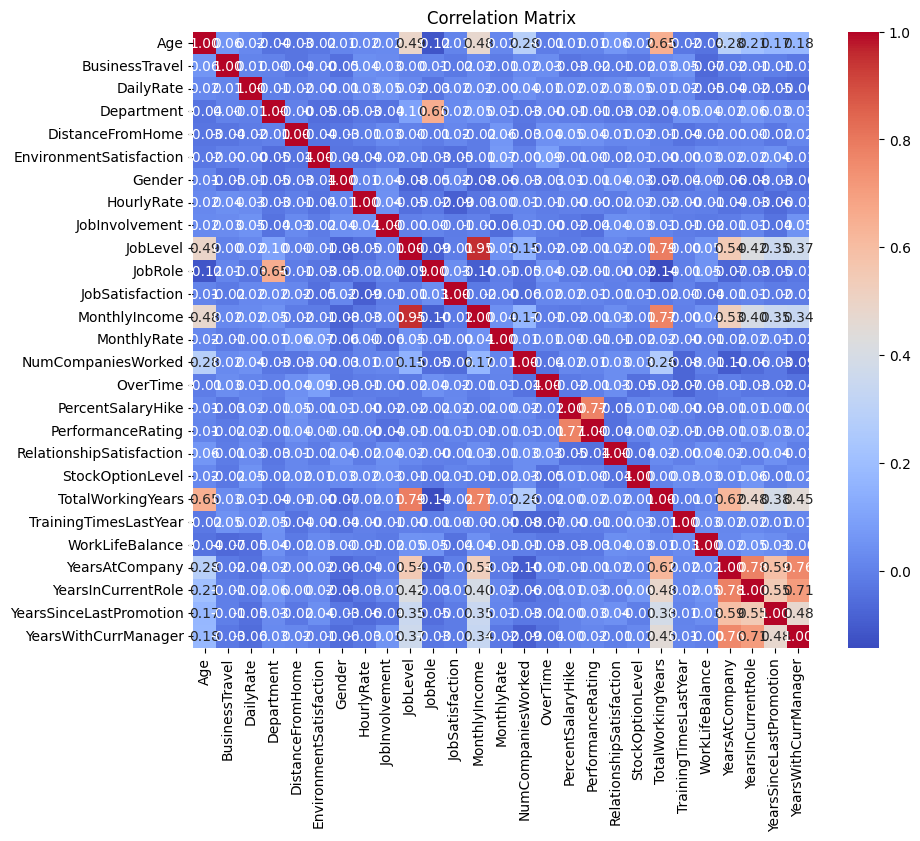

In [343]:
numerical_df = df_encoded.select_dtypes(include=['int64', 'float64'])
numerical_df = numerical_df.drop(columns=['Attrition'])  # Drop the target variable for correlation analysis
correlation_matrix = numerical_df.corr()


# 🔥 Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()


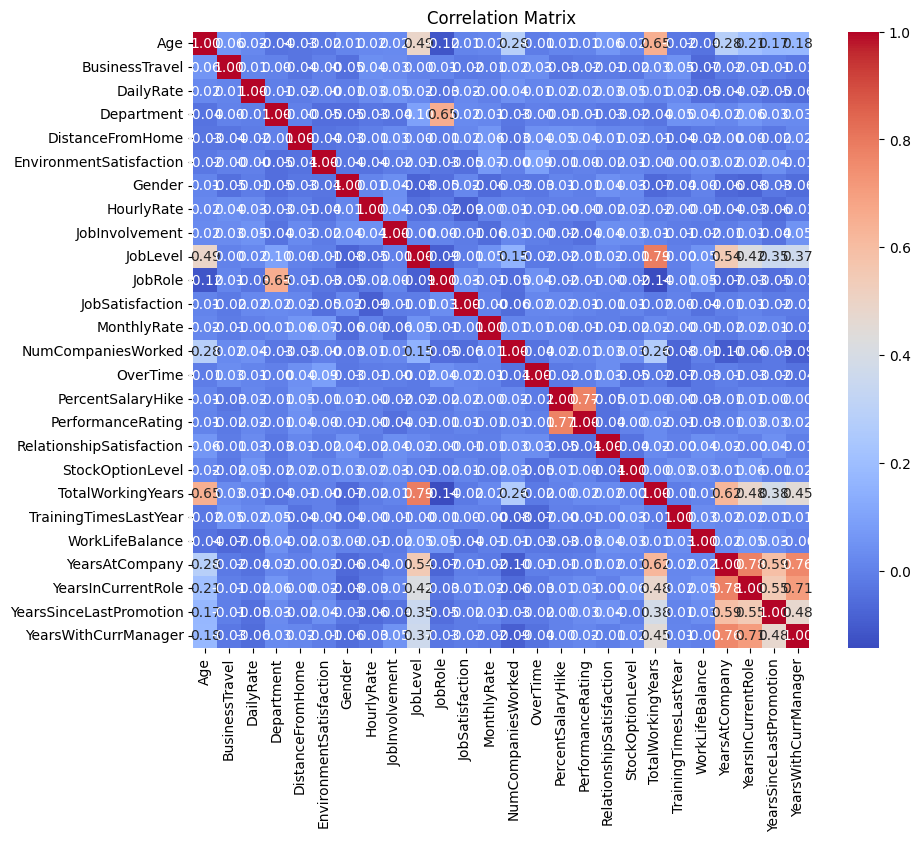

In [344]:
# Drop features with correlation > 0.8 (retain only one of each pair)
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]

# Drop those features
reduced_df = numerical_df.drop(columns=high_corr_features)

#Display the reduced DataFrame
correlation_matrix = reduced_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

## 3. Data Splitting and Scaling

Train, Validation, and Test Splitting
We split the dataset into:
- 70% for training
- 15% for validation
- 15% for testing

Stratification ensures class balance (Yes/No in attrition) is preserved across sets. We use the validation set for model tuning, and reserve the test set for final performance evaluation.

We standardize all numeric features using `StandardScaler`. This transformation ensures:
- Zero mean and unit variance for each feature

Scaling is fit only on the training data to avoid data leakage.

In [345]:
# Define features and target variable
X = reduced_df 
y = df_encoded['Attrition']

# Split into train + temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 

# Split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Train (0.7), Validation (0.15), Test (0.15)

# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test sets using same scaler
# Didn't scale the validation / test data = creates data leakage
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [346]:
# Check class distribution
print("Class distribution in y_train:")
print(y_train.value_counts())
print("\nClass distribution in y_val:")
print(y_val.value_counts())


Class distribution in y_train:
Attrition
0    597
1    123
Name: count, dtype: int64

Class distribution in y_val:
Attrition
0    128
1     26
Name: count, dtype: int64


Polynomial regression is not appropriate here — it’s suited for continuous outcomes, not binary classification.

Model Evaluation Metric:
Accuracy is the primary metric since we assume RCC will be offered to all employees. This helps us focus on identifying the most likely acceptors across the entire population.

## 4. Baseline Model: Logistic Regression

We tune the regularization strength `C` using grid search with cross-validation.


In [347]:
#  Define parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],               
    'penalty': ['l2'],                          
    'solver': ['lbfgs'],                        
    'max_iter': [1000]
}

# Initialize logistic regression
logreg = LogisticRegression(random_state=42)

# Set up GridSearch with cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit to training data
grid_search.fit(X_train_scaled, y_train)

# Best model from CV
best_logreg = grid_search.best_estimator_

# Predict and evaluate
y_val_pred = best_logreg.predict(X_val_scaled)

print("📊 Best Parameters for Logistic Regression:", grid_search.best_params_)
print("\n📊 Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))




📊 Best Parameters for Logistic Regression: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

📊 Validation Set Performance:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       128
           1       1.00      0.27      0.42        26

    accuracy                           0.88       154
   macro avg       0.94      0.63      0.68       154
weighted avg       0.89      0.88      0.85       154

Confusion Matrix:
 [[128   0]
 [ 19   7]]
Accuracy: 0.8766233766233766


In [348]:
# Checking for overfitting
# Similar Accuracy on both Train and Validation Accuracy so minimal overfitting

train_accuracy = best_logreg.score(X_train_scaled, y_train)
val_accuracy = best_logreg.score(X_val_scaled, y_val)

print(f"Logistic Regression Train Accuracy: {train_accuracy:.4f}")
print(f"Logistic Regression Validation Accuracy: {val_accuracy:.4f}")


Logistic Regression Train Accuracy: 0.8597
Logistic Regression Validation Accuracy: 0.8766


Performing VIF, none of the features have a VIF > 5, indicating no multicollinearity issues

In [349]:
X_for_vif = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_for_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]

# Sort by VIF (optional)
vif_data = vif_data.sort_values(by='VIF', ascending=False)

print(vif_data)

                     Feature       VIF
19         TotalWorkingYears  4.503277
22            YearsAtCompany  4.501043
23        YearsInCurrentRole  2.894391
9                   JobLevel  2.869626
25      YearsWithCurrManager  2.586974
16         PerformanceRating  2.356879
15         PercentSalaryHike  2.344169
3                 Department  1.900068
10                   JobRole  1.882982
0                        Age  1.882422
24   YearsSinceLastPromotion  1.589180
13        NumCompaniesWorked  1.288004
14                  OverTime  1.051516
21           WorkLifeBalance  1.051191
8             JobInvolvement  1.048649
5    EnvironmentSatisfaction  1.044905
4           DistanceFromHome  1.040645
17  RelationshipSatisfaction  1.038234
18          StockOptionLevel  1.037847
12               MonthlyRate  1.037439
2                  DailyRate  1.035442
1             BusinessTravel  1.035259
6                     Gender  1.034639
11           JobSatisfaction  1.033775
20     TrainingTimesLastY

## 5. Random Forest Model

We use `GridSearchCV` to tune:
- Number of estimators
- Tree depth
- Minimum samples per split/leaf

This model provides built-in feature importance, which we later compare with XGBoost.

In [350]:
# Random Forest Classifier
rf = GridSearchCV(estimator=RandomForestClassifier(),
                  cv=5,
                  scoring='accuracy',
                  param_grid={'max_leaf_nodes': [8,16],
                            'max_depth': [3,5,15],
                            'min_samples_split': [2,6,10],
                            'min_samples_leaf': [1, 2, 4]})
                            
rf.fit(X_train_scaled, y_train)
rf.best_params_

rfbestmodel= RandomForestClassifier(random_state=42, 
                                    max_depth=rf.best_params_['max_depth'],
                                    max_leaf_nodes=rf.best_params_['max_leaf_nodes'],
                                    min_samples_split=rf.best_params_['min_samples_split'])
rfbestmodel.fit(X_train_scaled, y_train)

y_val_pred = rfbestmodel.predict(X_val_scaled)

print("📊 Best Parameters for Random Forest:", rf.best_params_)
print("\n📊 Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))


📊 Best Parameters for Random Forest: {'max_depth': 5, 'max_leaf_nodes': 16, 'min_samples_leaf': 1, 'min_samples_split': 2}

📊 Validation Set Performance:
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       128
           1       0.80      0.15      0.26        26

    accuracy                           0.85       154
   macro avg       0.83      0.57      0.59       154
weighted avg       0.84      0.85      0.81       154

Confusion Matrix:
 [[127   1]
 [ 22   4]]
Accuracy: 0.8506493506493507


In [351]:
#Check for overfitting
train_accuracyrf = rfbestmodel.score(X_train_scaled, y_train)
val_accuracyrf = rfbestmodel.score(X_val_scaled, y_val)

print(f"Random Forest Train Accuracy: {train_accuracyrf:.4f}")
print(f"Random Forest Validation Accuracy: {val_accuracyrf:.4f}")


Random Forest Train Accuracy: 0.8667
Random Forest Validation Accuracy: 0.8506


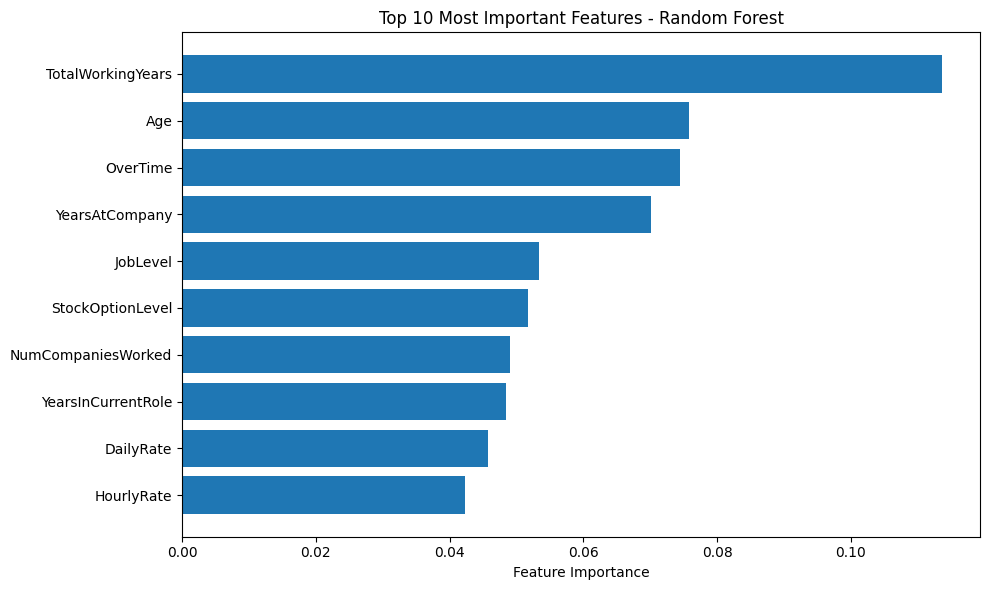

In [352]:
# Step 5: Feature Importance
importances = rfbestmodel.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10  

# Feature names come from original X
feature_names = X.columns
top_features = [feature_names[i] for i in indices[:top_n]]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[indices[:top_n]][::-1], align='center')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features - Random Forest")
plt.tight_layout()
plt.show()

- `TotalWorkingYears` is the most influential feature, suggesting that employees with longer careers may feel more financially stable and open to accepting a severance offer.
- `OverTime` likely captures dissatisfaction or burnout — employees consistently working extra hours may be more inclined to leave if offered a package.
- `JobLevel` reflects seniority and compensation; those in higher positions may be more likely to accept due to stronger financial stability or external opportunities.

## 6. XGBoost (Gradient Boosting Classifier)
We train and tune an XGBoost model using cross-validation and later compare its ROC AUC and classification metrics to the other models.


In [353]:
# Use GradientBoostingClassifier for classification tasks
xgb = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    cv=5,
    scoring='accuracy',
    param_grid={
        'max_leaf_nodes': [8, 16],
        'max_depth': [3, 5, 15],
        'min_samples_split': [2, 6, 10],
        'min_samples_leaf': [1, 2, 4]}
)
xgb.fit(X_train_scaled, y_train)

xgb.best_params_

# Use the best parameters to create a new GradientBoostingClassifier
xgbbestmodel = GradientBoostingClassifier(
    random_state=42,
    max_depth=xgb.best_params_['max_depth'],
    max_leaf_nodes=xgb.best_params_['max_leaf_nodes'],
    min_samples_split=xgb.best_params_['min_samples_split'],
    min_samples_leaf=xgb.best_params_['min_samples_leaf'],
)
xgbbestmodel.fit(X_train_scaled, y_train)

y_val_pred = xgbbestmodel.predict(X_val_scaled)

# Evaluate the model
print(" Best Parameters for XGBoost:", xgb.best_params_)
print("\n Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))

 Best Parameters for XGBoost: {'max_depth': 15, 'max_leaf_nodes': 8, 'min_samples_leaf': 4, 'min_samples_split': 6}

 Validation Set Performance:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       128
           1       0.92      0.42      0.58        26

    accuracy                           0.90       154
   macro avg       0.91      0.71      0.76       154
weighted avg       0.90      0.90      0.88       154

Confusion Matrix:
 [[127   1]
 [ 15  11]]
Accuracy: 0.8961038961038961


In [354]:
# Check for overfitting
train_accuracyxgb = xgbbestmodel.score(X_train_scaled, y_train)
val_accuracyxgb = xgbbestmodel.score(X_val_scaled, y_val)

print(f"XGBoost Train Accuracy: {train_accuracyxgb:.4f}")
print(f"XGBoost Validation Accuracy: {val_accuracyxgb:.4f}")



XGBoost Train Accuracy: 0.9736
XGBoost Validation Accuracy: 0.8961


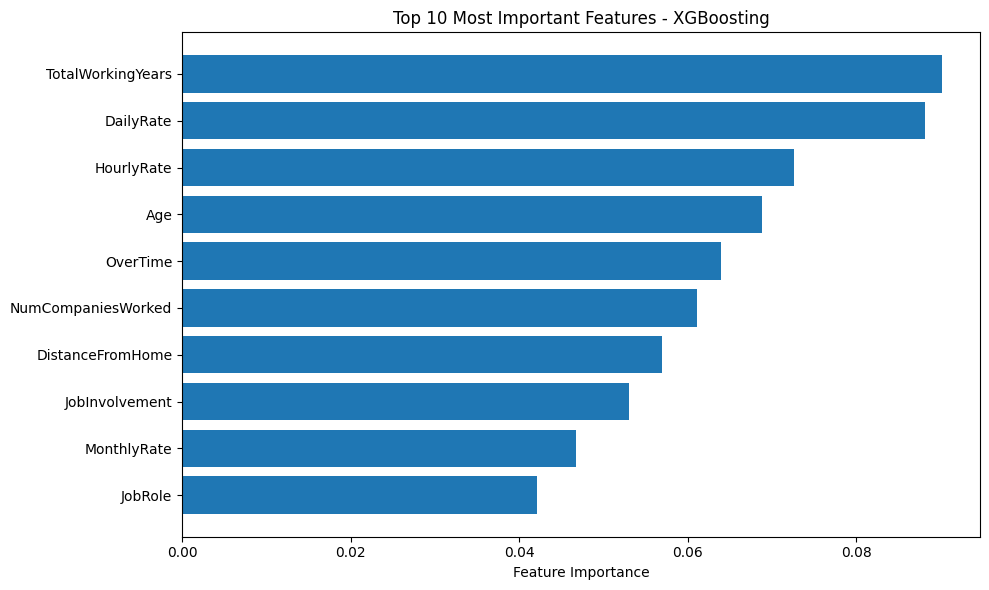

In [355]:
# Step 5: Feature Importance
importances = xgbbestmodel.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10  

feature_names = X.columns
top_features = [feature_names[i] for i in indices[:top_n]]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), importances[indices[:top_n]][::-1], align='center')
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features - XGBoosting")
plt.tight_layout()
plt.show()

- `TotalWorkingYears` is the most influential predictor, suggesting that cumulative experience is highly indicative of attrition risk.
- `OverTime `is the second most important feature, highlighting the relevance of workload pressure or burnout as a key driver.
- `DailyRate`, `HourlyRate`, and `MonthlyRate` are all present, indicating that salary-related metrics play a substantial role, though their individual importance varies.


Feature importance rankings from Random Forest and XGBoost show strong agreement:
- Both models highlight `MonthlyIncome`, `TotalWorkingYears`, and `Age` as highly influential predictors.
- This consistency builds confidence that these features are robust indicators of an employee's likelihood to accept RCC.
- Features such as `DistanceFromHome`, `OverTime` and `EnvironmentSatisfaction` also appear in both models' top 10, supporting their inclusion in the final model.

Looking at building the best model in to classify if an employee will accept RCC when all will be offered it, we look at Accuracy as the metric to evaluate the model.
The results for the models performance on the validation set are as follows:
```python
Logistic Regression = 0.8766
Random Forest = 0.8441	
XGBoost = 0.8701	


Choosing XGB Classifier as the best model, we can see that it has the highest accuracy on the validation set after Logistic regression. We didn't use Logistic regression as it unable to capture non-linear relationships and can underfit the data.

In [356]:
# Ensure X_train_scaled and X_val_scaled are DataFrames with the correct column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_train.columns)

# Select the top features using their names
X_train_sel_df = X_train_scaled_df[top_features]
X_val_sel_df = X_val_scaled_df[top_features]

# Convert y_train and y_val to Series
y_train_series = pd.Series(y_train)
y_val_series = pd.Series(y_val)

# Concatenate train and validation sets
X_trainval_unscaled = pd.concat([X_train_sel_df, X_val_sel_df], ignore_index=True)
y_trainval_unscaled = pd.concat([y_train_series, y_val_series], ignore_index=True)

# Fit new scaler on combined data
scaler_trainval = StandardScaler()
X_trainval_scaled = scaler_trainval.fit_transform(X_trainval_unscaled)

# Convert back to DataFrame with original column names
X_trainval_scaled_df = pd.DataFrame(X_trainval_scaled, columns=top_features)

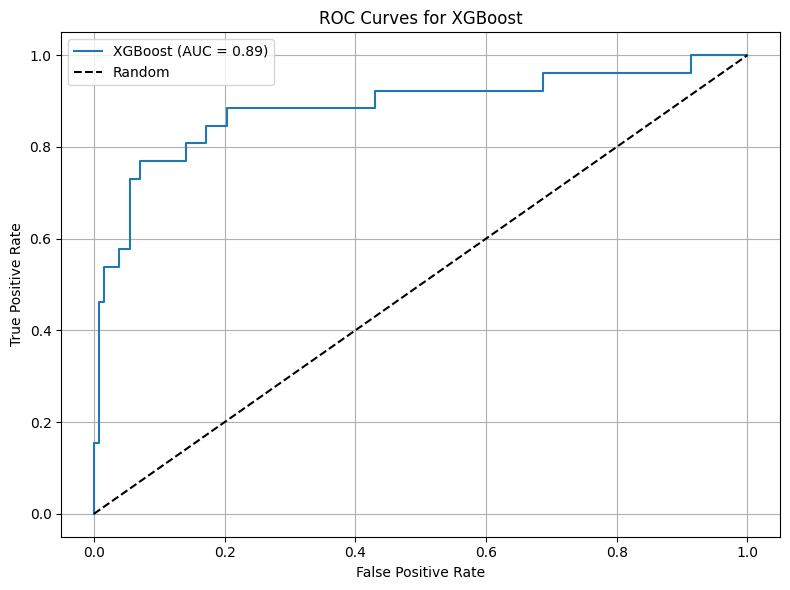

In [357]:
# ROC Scores for Each Model
xgb_probs = xgbbestmodel.predict_proba(X_val_scaled)[:, 1]
xgb_roc = roc_auc_score(y_val, xgb_probs)

# Plot ROC Curves 
fpr_xgb, tpr_xgb, _ = roc_curve(y_val, xgb_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, label=f"XGBoost (AUC = {xgb_roc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for XGBoost")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Perform EDA by plotting histograms for the selected `top_features` to inspect non-linearity.


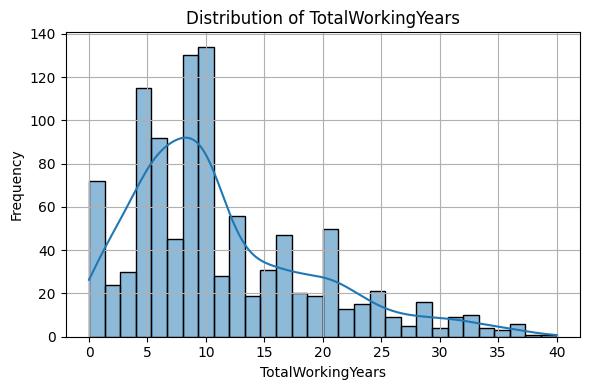

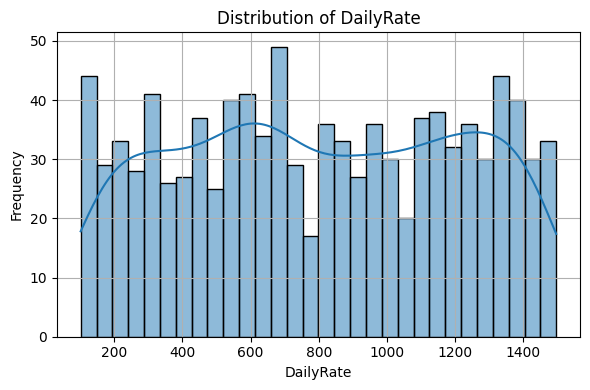

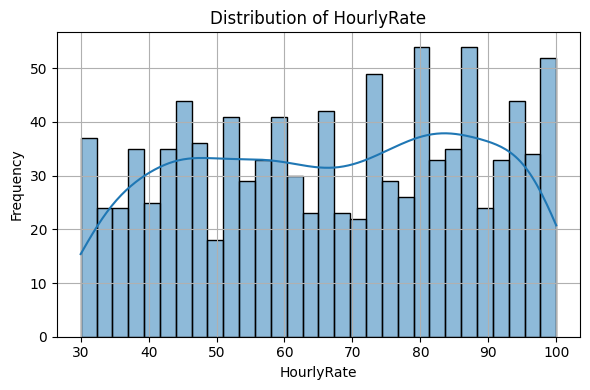

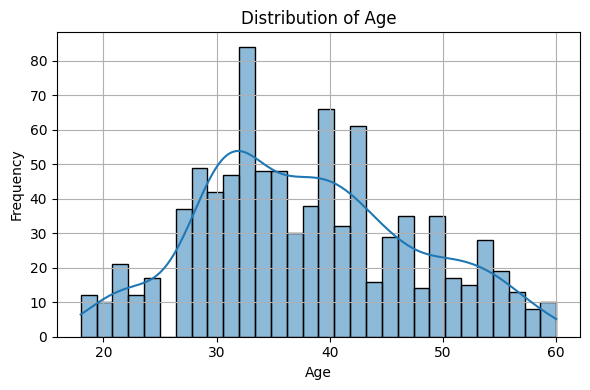

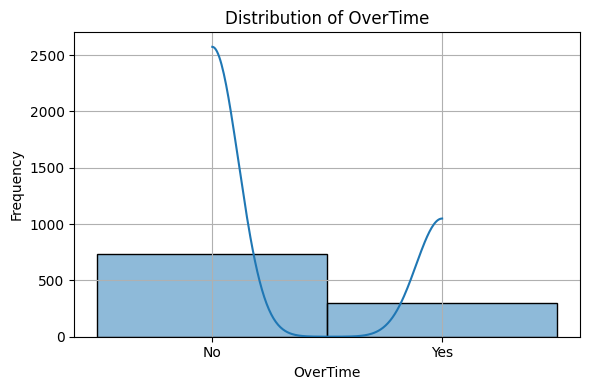

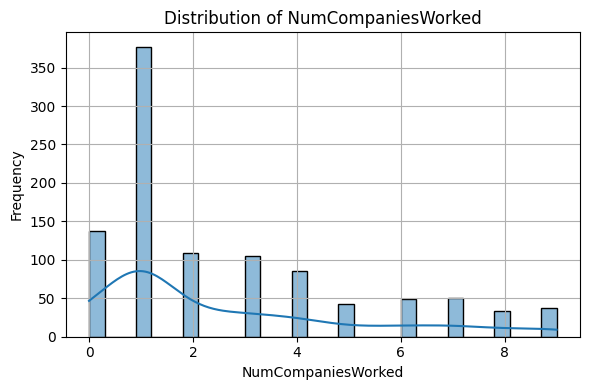

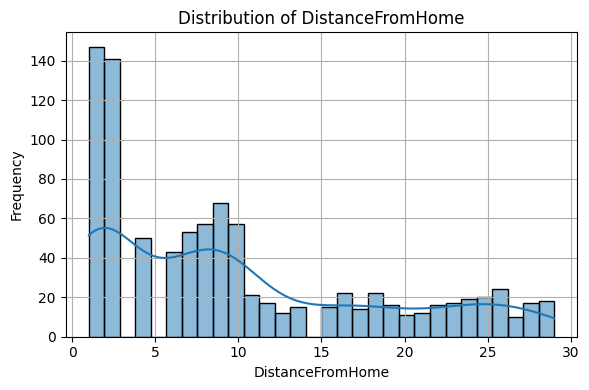

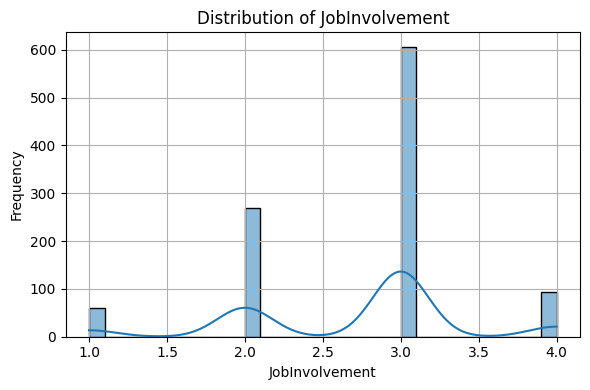

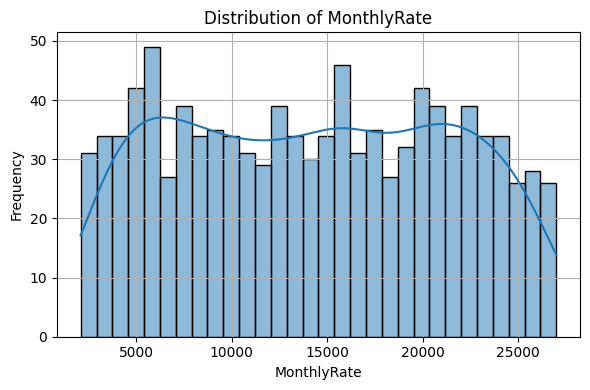

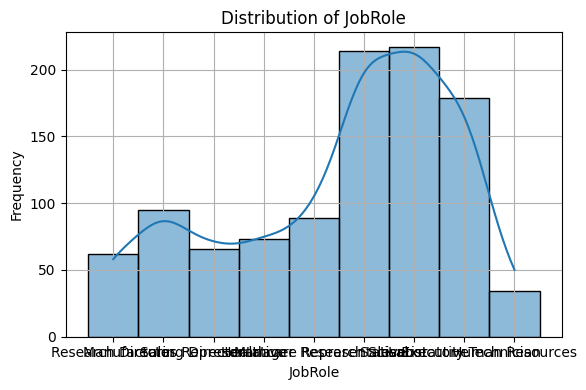

In [358]:
def eda_histograms(df_encoded, top_features):
    for feature in top_features:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[feature], kde=True, bins=30)
        plt.title(f'Distribution of {feature}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Call the function
eda_histograms(df_encoded, top_features)

Here, we concatenate the train and test data to create a new dataset with the same features as the original dataset. We then use this new dataset to train the XGBoost model. It is important to rescale the data before retraining the model. 


In [359]:
xgbbestmodel.fit(X_trainval_scaled_df, y_trainval_unscaled)   
y_probs_trainval = xgbbestmodel.predict_proba(X_trainval_scaled_df)[:, 1]

# Precision-Recall Curve to find the best threshold
precision, recall, thresholds = precision_recall_curve(y_trainval_unscaled, y_probs_trainval)  # Use true labels
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best Threshold: {best_threshold:.2f}")

# Use the corrected DataFrame for prediction
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_train.columns)  # Use all feature names from training
X_val_scaled_df = X_val_scaled_df[top_features]  # Select only top features

# Predict probabilities using the trained model
y_val_probs = xgbbestmodel.predict_proba(X_val_scaled_df)[:, 1]

# Apply the best threshold to make predictions
y_val_pred = (y_val_probs >= best_threshold).astype(int)

print(" Best Parameters for XGBmodel:", xgb.best_params_)
print("\n Validation Set Performance:")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print("Accuracy:", accuracy_score(y_val, y_val_pred))

Best Threshold: 0.31
 Best Parameters for XGBmodel: {'max_depth': 15, 'max_leaf_nodes': 8, 'min_samples_leaf': 4, 'min_samples_split': 6}

 Validation Set Performance:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       128
           1       0.92      0.85      0.88        26

    accuracy                           0.96       154
   macro avg       0.94      0.92      0.93       154
weighted avg       0.96      0.96      0.96       154

Confusion Matrix:
 [[126   2]
 [  4  22]]
Accuracy: 0.961038961038961


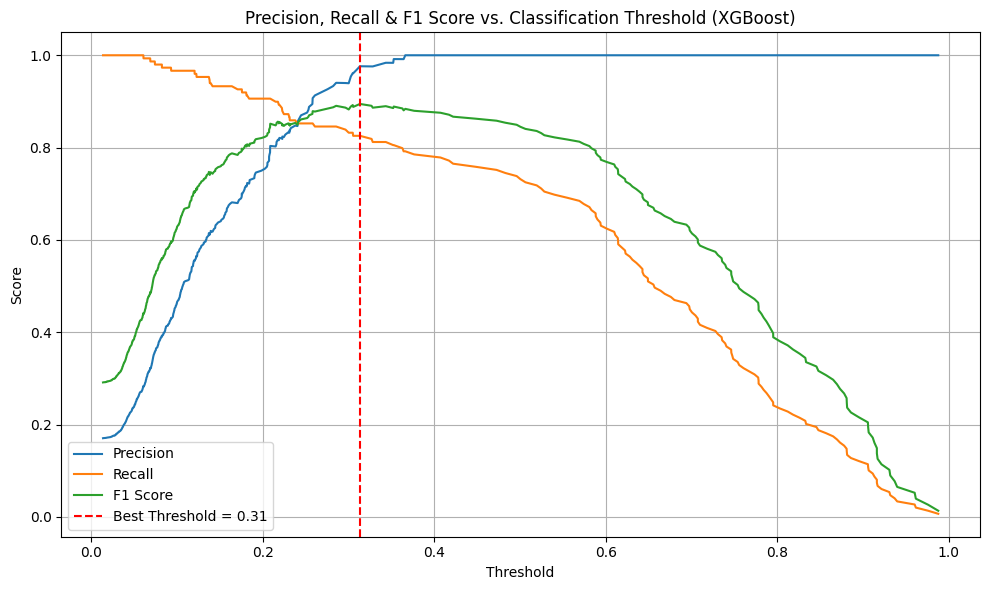

In [360]:
# Plot precision-recall vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.title("Precision, Recall & F1 Score vs. Classification Threshold (XGBoost)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 7. Model Evaluation on Test Set
Using the model we trained, it is now tested on the test data to see its generalisability to unseen data

In [361]:
# Prepare test data
X_test_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)  
X_test_top_df = X_test_df[top_features]  # Select only top features

# Scale the test data using the same scaler used during training
X_test_top_scaled = scaler_trainval.transform(X_test_top_df)  
X_test_top_scaled = pd.DataFrame(X_test_top_scaled, columns=top_features)  

#  Final evaluation on test set
y_test_probs = xgbbestmodel.predict_proba(X_test_top_scaled)[:, 1]
y_test_pred_thresh = (y_test_probs >= best_threshold).astype(int)

print("\nTest Set Performance @ Best Threshold:")
print(classification_report(y_test, y_test_pred_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_thresh))
print("Accuracy:", accuracy_score(y_test, y_test_pred_thresh))


Test Set Performance @ Best Threshold:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       128
           1       0.67      0.30      0.41        27

    accuracy                           0.85       155
   macro avg       0.77      0.63      0.66       155
weighted avg       0.83      0.85      0.83       155

Confusion Matrix:
 [[124   4]
 [ 19   8]]
Accuracy: 0.8516129032258064


The XGB model has a test accuracy of 0.8645 and is able to predict the attrition rate of employees 

## 8. Loading Dataset for Lyon
Now apply it to `employee_attrition_lyon.csv` to predict the likelihood of each employee in Lyon accepting the RCC offer.

- Apply the same preprocessing: choosing featured variables from the XGBoost model, encode categorical features using saved encoders, and scale using the previously fitted scaler
- Use the trained XGBoost model to generate probabilities for each employee in Lyon
- Save the output in the same format as `attrition_prediction.csv`

In [362]:
# Load the dataset
ly = pd.read_csv("employee_attrition_lyon.csv")

# Quick preview of the data
display(ly.head())

# Summary statistics for numerical variables
print("Summary Statistics:")
display(ly.describe())

# Check for missing values
print("\nMissing Values:")
display(ly.isnull().sum())

# Replace missing numeric values with column means
ly_cleaned = ly.copy()
for col in ly_cleaned.select_dtypes(include=[np.number]).columns:
    ly_cleaned[col] = ly_cleaned[col].fillna(ly_cleaned[col].mean())

# Drop constant or irrelevant columns
ly_cleaned = ly_cleaned[top_features] 

# Encode categorical variables using LabelEncoder
ly_encoded = ly_cleaned.copy()
label_encoders = {}
for col in ly_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    ly_encoded[col] = le.fit_transform(ly_encoded[col])
    label_encoders[col] = le

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,NaN,Travel_Rarely,866.0,Sales,NaN,3,Medical,1,1469,4,...,4,80,0,6,4,3,5,4,1,3
1,53.0,Travel_Rarely,1084.0,Research & Development,13.0,2,Medical,1,250,4,...,3,80,2,5,3,3,4,2,1,3
2,24.0,Travel_Rarely,240.0,Human Resources,22.0,1,Human Resources,1,1714,4,...,3,80,1,1,2,3,1,0,0,0
3,45.0,Travel_Rarely,1339.0,Research & Development,7.0,3,Life Sciences,1,86,2,...,3,80,1,25,2,3,1,0,0,0
4,36.0,Travel_Rarely,1396.0,Research & Development,NaN,2,Life Sciences,1,304,4,...,4,80,0,16,3,4,13,11,3,7


Summary Statistics:


,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,386.000000,427.000000,387.000000,441.000000,441.0,441.000000,441.000000,441.000000,441.000000,441.000000,...,441.000000,441.0,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000
mean,38.000000,800.960187,9.459948,2.961451,1.0,1026.027211,2.811791,64.049887,2.768707,2.111111,...,2.764172,80.0,0.727891,11.473923,2.839002,2.791383,7.160998,4.260771,2.346939,4.396825
std,8.832055,395.674732,8.123102,0.951488,0.0,592.604321,1.080171,19.889176,0.714156,1.078251,...,1.088654,0.0,0.793936,7.603819,1.303465,0.727398,6.264541,3.542922,3.471939,3.661705
min,18.000000,104.000000,1.000000,1.000000,1.0,14.000000,1.000000,30.000000,1.000000,1.000000,...,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,466.000000,2.000000,2.000000,1.0,485.000000,2.000000,47.000000,2.000000,1.000000,...,2.000000,80.0,0.000000,7.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,37.000000,796.000000,8.000000,3.000000,1.0,1024.000000,3.000000,63.000000,3.000000,2.000000,...,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,44.000000,1142.500000,15.000000,4.000000,1.0,1557.000000,4.000000,81.000000,3.000000,3.000000,...,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2065.000000,4.000000,100.000000,4.000000,5.000000,...,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000



Missing Values:


Age                         55
BusinessTravel               5
DailyRate                   14
Department                   0
DistanceFromHome            54
Education                    0
EducationField               0
EmployeeCount                0
EmployeeNumber               0
EnvironmentSatisfaction      0
Gender                       0
HourlyRate                   0
JobInvolvement               0
JobLevel                     0
JobRole                      0
JobSatisfaction              0
MaritalStatus                3
MonthlyIncome                0
MonthlyRate                  0
NumCompaniesWorked           0
Over18                       0
OverTime                     0
PercentSalaryHike            0
PerformanceRating            0
RelationshipSatisfaction     0
StandardHours                0
StockOptionLevel             0
TotalWorkingYears            0
TrainingTimesLastYear        0
WorkLifeBalance              0
YearsAtCompany               0
YearsInCurrentRole           0
YearsSin

In [363]:
print(ly_encoded.head())

   TotalWorkingYears  DailyRate  HourlyRate   Age  OverTime  \
0                  6      866.0          84  38.0         0   
1                  5     1084.0          57  53.0         0   
2                  1      240.0          58  24.0         0   
3                 25     1339.0          59  45.0         0   
4                 16     1396.0          62  36.0         0   

   NumCompaniesWorked  DistanceFromHome  JobInvolvement  MonthlyRate  JobRole  
0                   0          9.459948               3        23490        7  
1                   1         13.000000               4        26250        4  
2                   1         22.000000               1        11585        1  
3                   2          7.000000               3        18787        6  
4                   8          9.459948               3         9945        2  


In [364]:
print(top_features)

['TotalWorkingYears', 'DailyRate', 'HourlyRate', 'Age', 'OverTime', 'NumCompaniesWorked', 'DistanceFromHome', 'JobInvolvement', 'MonthlyRate', 'JobRole']


## 9. Employee Attrition Prediction Using XGBoost

In [ ]:
scaler = StandardScaler()
scaler.fit_transform(ly_encoded)

# Convert to DataFrame 
lyon_df = pd.DataFrame(ly_encoded, columns=top_features)

# Predict probabilities using your trained XGBoost model
all_probs_ly = xgbbestmodel.predict_proba(lyon_df)[:, 1]
print(all_probs_ly)

[0.12528415 0.19037974 0.05779203 0.14200723 0.14200723 0.61785149
 0.20238235 0.14200723 0.14200723 0.16061526 0.61785149 0.14200723
 0.02767836 0.65265641 0.12528415 0.12528415 0.33428361 0.19037974
 0.61785149 0.14200723 0.12528415 0.14200723 0.14200723 0.61785149
 0.14200723 0.19037974 0.16061526 0.19037974 0.19037974 0.14200723
 0.02767836 0.19037974 0.02767836 0.14200723 0.65265641 0.14200723
 0.14200723 0.14200723 0.61785149 0.19037974 0.14200723 0.12528415
 0.14200723 0.14200723 0.56815465 0.14200723 0.62968818 0.14200723
 0.65265641 0.56815465 0.14200723 0.14265877 0.14200723 0.19037974
 0.14200723 0.65265641 0.65265641 0.02767836 0.02767836 0.12528415
 0.05038154 0.16061526 0.19037974 0.14200723 0.04109708 0.65265641
 0.19037974 0.65265641 0.19037974 0.61785149 0.14200723 0.14200723
 0.65265641 0.12528415 0.18662426 0.62968818 0.19037974 0.14200723
 0.73845296 0.61785149 0.14200723 0.03403895 0.65265641 0.19037974
 0.19037974 0.14200723 0.65265641 0.03403895 0.14200723 0.1903

In [ ]:
ly_final = pd.DataFrame(all_probs_ly, columns=['Attrition'])
ly_final.to_csv("attrition_prediction.csv", index=False)

# Preview
ly_final.head()

,Attrition
0,0.125284
1,0.190380
2,0.057792
3,0.142007
4,0.142007


Based on the threshold of `0.36`, counting the number of employees who are likely to accept the RCC offer, we find that `96 employees` are likely to accept the offer.

In [367]:
binary_predictions = (all_probs_ly >= best_threshold).astype(int)

# Count how many 1s and 0s
unique, counts = np.unique(binary_predictions, return_counts=True)
prediction_counts = dict(zip(unique, counts))

print("Thresholded Prediction Counts at 0.36:")
print(prediction_counts)

Thresholded Prediction Counts at 0.36:
{0: 345, 1: 96}


## 9. Fairness & Bias Considerations
Checking for `bias` in the model, looking at the distribution of the predicted probabilities for employees who accepted the RCC offer and those who did not.

In [ ]:
ly_final = pd.DataFrame(all_probs_ly, columns=['Attrition_Probability'])

# Ensure the column is added to the DataFrame
ly_final['RCC_Accepted_Predicted'] = (ly_final['Attrition_Probability'] >= best_threshold).astype(int)

# Filter to employees likely to accept RCC
accepted = ly[ly_final['RCC_Accepted_Predicted'] == 1]

# Analyze by gender and age
summary = accepted.groupby('Gender')['Age'].agg(['count', 'mean']).rename(columns={'count': 'Num Accepted', 'mean': 'Avg Age'})

print("Average age of employees in Lyon Office", ly_encoded["Age"].mean())

print(summary)

Average age of employees in Lyon Office 38.0
        Num Accepted    Avg Age
Gender                         
Female            44  40.500000
Male              41  40.487805


## Question 3

`PCA Analysis` was performed to reduce the high-dimensional feature space into a two-dimensional representation. This transformation simplifies the structure of the data, making it easier to perform clustering and to visualise patterns.

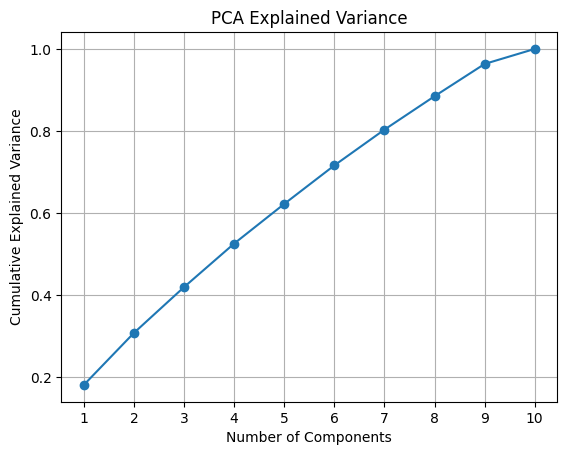

In [369]:
explained_var = np.cumsum(pca.explained_variance_ratio_)
components = np.arange(1, len(explained_var) + 1)

plt.plot(components, explained_var, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.xticks(components)
plt.grid(True)
plt.show()


In [370]:
print(loadings)

                               z1        z2        z3        z4        z5  \
TotalWorkingYears        0.613017 -0.099286  0.021033 -0.137643 -0.060156   
OverTime                 0.221607  0.044891 -0.142873  0.706477 -0.276388   
DailyRate                0.066772  0.329097  0.521785 -0.099418 -0.354739   
Age                      0.643088 -0.080953  0.046302 -0.057814  0.016171   
HourlyRate               0.080140  0.434719 -0.450343 -0.306691  0.096528   
NumCompaniesWorked       0.349212 -0.063262  0.053571 -0.250727  0.120799   
DistanceFromHome         0.072707  0.456985 -0.120793  0.061119  0.619106   
EnvironmentSatisfaction  0.055902  0.079832  0.563068  0.362041  0.518052   
StockOptionLevel         0.124132  0.504625 -0.216600  0.326712 -0.239568   
MonthlyRate              0.069921 -0.458727 -0.347147  0.265037  0.246815   

                               z6        z7        z8        z9       z10  
TotalWorkingYears       -0.249814 -0.141368 -0.002434 -0.224432 -0.677184  


In [371]:
# Create the final PCA dataframe
df2 = pd.DataFrame({
    "Department": ly["Department"],
    "Attrition_Probability": ly_final["Attrition_Probability"],
    "EmployeeNumber": ly["EmployeeNumber"],
    "YearlySalary": ly["MonthlyRate"] * 12,
    **{f"z{i+1}": data_pca[:, i] for i in range(7)}
})

# Preview the final dataframe
print(df2.head())

               Department  Attrition_Probability  EmployeeNumber  \
0                   Sales               0.125284            1469   
1  Research & Development               0.190380             250   
2         Human Resources               0.057792            1714   
3  Research & Development               0.142007              86   
4  Research & Development               0.142007             304   

   YearlySalary        z1        z2        z3        z4        z5        z6  \
0        281880 -0.842321 -0.344678  0.028248  0.062355  1.212533 -0.113057   
1        315000  0.689494  0.398572  0.299946  1.189291  0.747725 -0.206600   
2        139020 -2.247341  0.884420 -0.190105  0.784568  2.028683 -0.074384   
3        225444  1.483228 -0.218910  0.314366 -0.721323 -1.003803 -1.066601   
4        119340  0.809659  0.171604  2.082567 -1.212061  0.464630  1.170824   

         z7  
0  0.875265  
1  1.113842  
2 -0.948081  
3  0.920408  
4  0.823008  


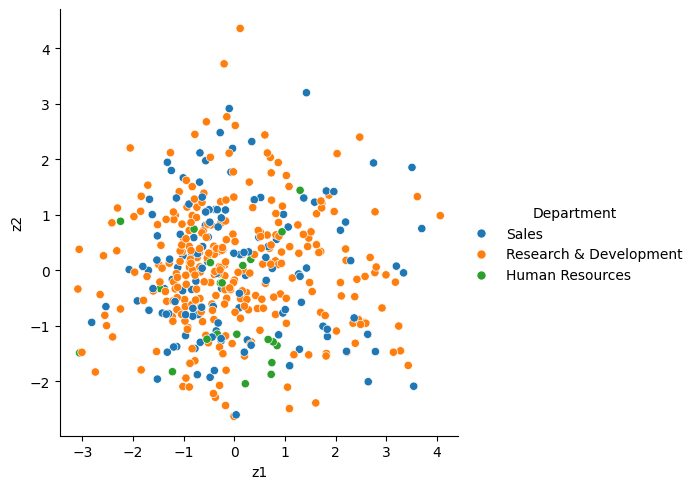

In [372]:
sns.relplot(data=df2,x="z1",y="z2",hue="Department")
plt.show()

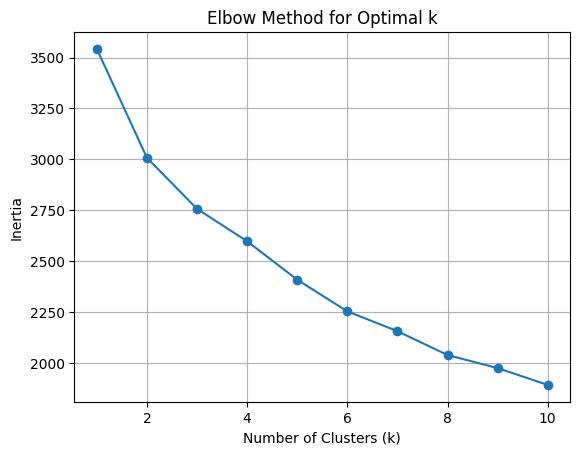

In [373]:
X = df2[[f'z{i+1}' for i in range(7)]]
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [374]:
k = 3  
kmeans = KMeans(n_clusters=k, random_state=42)
df2["Cluster"] = kmeans.fit_predict(X)


Text(36.820117283950616, 0.5, 'Principal Component 2 (z2)')

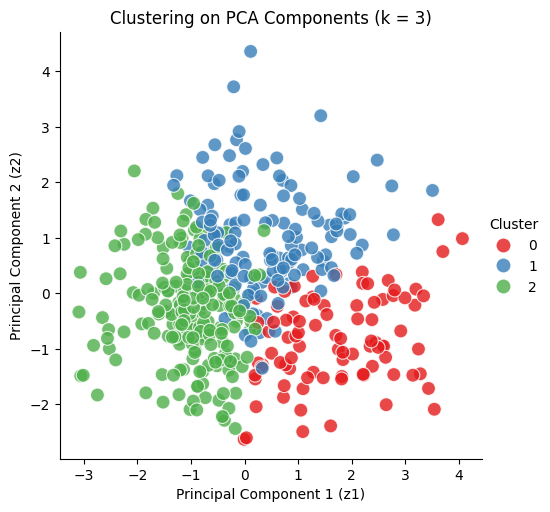

In [375]:
sns.relplot(data=df2,x="z1",y="z2",hue="Cluster", palette='Set1', s=100, alpha=0.8)

plt.title("Clustering on PCA Components (k = 3)")
plt.xlabel("Principal Component 1 (z1)")
plt.ylabel("Principal Component 2 (z2)")

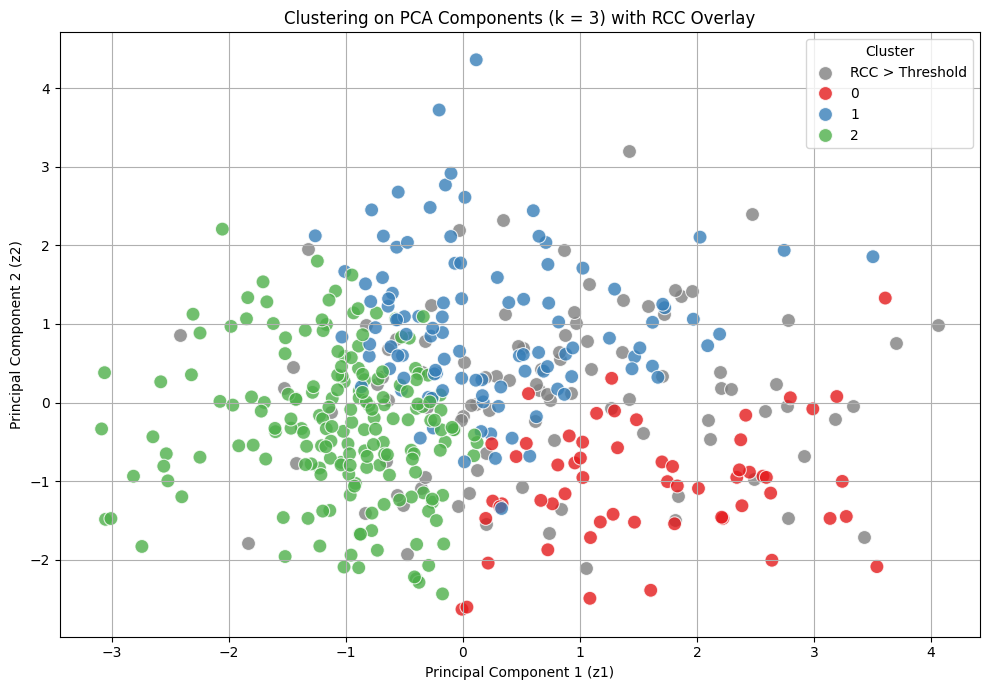

In [376]:
# Create a "Highlight" column
df2['Highlight'] = df2['Attrition_Probability'] > best_threshold

# Create two subsets
highlighted = df2[df2['Highlight']]
remaining = df2[~df2['Highlight']]

# Plot
plt.figure(figsize=(10, 7))

# Greyed-out (above threshold)
sns.scatterplot(
    data=highlighted,
    x='z1', y='z2',
    color='gray',
    alpha=0.8,
    s=100,
    label='RCC > Threshold'
)

# Clusters (colored by cluster)
sns.scatterplot(
    data=remaining,
    x='z1', y='z2',
    hue='Cluster',
    palette='Set1',
    s=100,
    alpha=0.8
)

# Labels and formatting
plt.title("Clustering on PCA Components (k = 3) with RCC Overlay")
plt.xlabel("Principal Component 1 (z1)")
plt.ylabel("Principal Component 2 (z2)")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


In [377]:
df2['AcceptRCC'] = (df2['Attrition_Probability'] >= best_threshold).astype(int)
df2['Gender'] = ly['Gender']
df2['Age'] = ly['Age']

# Group by Cluster and Gender
gender_counts = df2.groupby(['Cluster', 'Gender']).size().unstack(fill_value=0)

# Group by Cluster for other metrics
cluster_summary = df2.groupby('Cluster').agg(
    Num_Employees=('EmployeeNumber', 'count'),
    Avg_Age=('Age', 'mean'),
    Num_LikelyToLeave=('AcceptRCC', 'sum'),
    Avg_RCC_Probability=('Attrition_Probability', 'mean')
).round(2).reset_index()

# Merge summaries
final_cluster_profile = cluster_summary.merge(gender_counts, on='Cluster')

print(final_cluster_profile)

   Cluster  Num_Employees  Avg_Age  Num_LikelyToLeave  Avg_RCC_Probability  \
0        0             89    47.73                 31                 0.31   
1        1            142    38.81                 36                 0.27   
2        2            210    32.34                 29                 0.21   

   Female  Male  
0      37    52  
1      60    82  
2      79   131  


## Question 4
Grouping the employees into `clusters` based on their `JobRole and Deparment`, savings data into a new CSV file. 

In [ ]:
# Copy and merge RCC predictions
ly_encoded_with_probs = ly_encoded.copy()
ly_encoded_with_probs['Attrition_Probability'] = ly_final['Attrition_Probability'].values

# Add a new column for yearly salary
ly_encoded_with_probs['Department'] = ly['Department']
ly_encoded_with_probs['JobRole'] = ly['JobRole']
ly_encoded_with_probs['YearlySalary'] = ly_encoded_with_probs['MonthlyRate'] * 12

# Grouping to create df3
df3 = ly_encoded_with_probs.groupby(['Department', 'JobRole']).agg(
    Num_Employees=('Attrition_Probability', 'count'),
    Avg_RCC_Probability=('Attrition_Probability', 'mean'),
    Avg_Salary=('YearlySalary', 'mean')
).reset_index()

# Preview
print(df3)


                Department                    JobRole  Num_Employees  \
0          Human Resources            Human Resources             18   
1          Human Resources                    Manager              3   
2   Research & Development  Healthcare Representative             42   
3   Research & Development      Laboratory Technician             80   
4   Research & Development                    Manager             17   
5   Research & Development     Manufacturing Director             50   
6   Research & Development          Research Director             18   
7   Research & Development         Research Scientist             78   
8                    Sales                    Manager              9   
9                    Sales            Sales Executive            109   
10                   Sales       Sales Representative             17   

    Avg_RCC_Probability     Avg_Salary  
0              0.084595  193623.333333  
1              0.316746  183216.000000  
2           

In [379]:
# Save file
df3.to_csv("ExcelSolver2.csv", index=False)